In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import json
from pathlib import Path
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Global constants (matching Milestone 1)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Project paths
DATASET_PATH = "DATASET"
OUTPUT_DIR = "output"
MODEL_DIR = os.path.join(OUTPUT_DIR, "models")

# Create directories if they don't exist
for dir_path in [OUTPUT_DIR, MODEL_DIR]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete")

✅ Environment setup complete


In [3]:
# Configure data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VALIDATION_SPLIT
)

# Create generators
print("Creating training generator...")
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

print("\nCreating validation generator...")
validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)

print(f"\n✅ Data Generators Ready:")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print("Class mapping:", train_generator.class_indices)

Creating training generator...
Found 961 images belonging to 4 classes.

Creating validation generator...
Found 240 images belonging to 4 classes.

✅ Data Generators Ready:
Number of classes: 4
Training samples: 961
Validation samples: 240
Class mapping: {'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}

Creating validation generator...
Found 240 images belonging to 4 classes.

✅ Data Generators Ready:
Number of classes: 4
Training samples: 961
Validation samples: 240
Class mapping: {'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}


In [4]:
# Create base model with pretrained weights
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze base model layers
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [5]:
# Set up callbacks
checkpoint_path = os.path.join(MODEL_DIR, 'base_model_checkpoint.h5')
csv_path = os.path.join(OUTPUT_DIR, 'training_history.csv')

callbacks = [
    ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    CSVLogger(csv_path)
]

# Train the model
EPOCHS = 15
print("Training base model...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("\n✅ Base model training complete")

# Save the trained model
base_model_path = os.path.join(MODEL_DIR, 'base_model.h5')
model.save(base_model_path)
print(f"Model saved to {base_model_path}")

Training base model...
Epoch 1/15
Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5036 - loss: 1.0933

30/30 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6329 - loss: 0.8889 - val_accuracy: 0.8705 - val_loss: 0.4678
Epoch 2/15
Epoch 2/15
 1/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7188 - loss: 0.6702

c:\Users\nimba_7qa63ab\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 335ms/step - accuracy: 0.7188 - loss: 0.6702 - val_accuracy: 0.8705 - val_loss: 0.4574
Epoch 3/15
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8024 - loss: 0.5449

30/30 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7836 - loss: 0.5621 - val_accuracy: 0.8884 - val_loss: 0.3955
Epoch 4/15
Epoch 4/15
 1/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.7500 - loss: 0.7084

30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 373ms/step - accuracy: 0.7500 - loss: 0.7084 - val_accuracy: 0.8929 - val_loss: 0.3968
Epoch 5/15
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8224 - loss: 0.4895 - val_accuracy: 0.8929 - val_loss: 0.3484
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8224 - loss: 0.4895 - val_accuracy: 0.8929 - val_loss: 0.3484
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.9062 - loss: 0.4506 - val_accuracy: 0.8884 - val_loss: 0.3567
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.9062 - loss: 0.4506 - val_accuracy: 0.8884 - val_loss: 0.3567
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8116 - loss: 0.4789 - val_accuracy: 0.8839 - val_loss: 0.3375
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8116 - loss: 0.4789 - val_accuracy: 0.8839 - val_loss: 0.3375
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.7500 - loss: 0.5524 - val_accuracy: 0.8795 - 


✅ Base model training complete
Model saved to output\models\base_model.h5
Model saved to output\models\base_model.h5


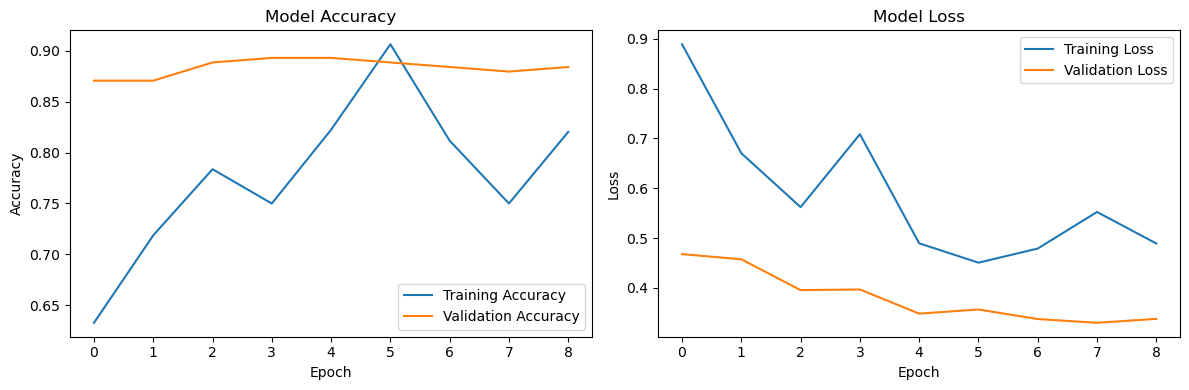


✅ Training history plot saved to output\training_history.png


In [6]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

# Save the plot
history_plot_path = os.path.join(OUTPUT_DIR, 'training_history.png')
plt.savefig(history_plot_path)
plt.show()

print(f"\n✅ Training history plot saved to {history_plot_path}")

In [7]:
# Unfreeze the base model
base_model.trainable = True

# Freeze first half of the base model layers
num_layers = len(base_model.layers)
freeze_until = num_layers // 2
for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display updated model
model.summary()

# Set up callbacks for fine-tuning
fine_tune_checkpoint = os.path.join(MODEL_DIR, 'fine_tuned_checkpoint.h5')
fine_tune_csv = os.path.join(OUTPUT_DIR, 'fine_tuning_history.csv')

fine_tune_callbacks = [
    ModelCheckpoint(
        fine_tune_checkpoint,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    CSVLogger(fine_tune_csv)
]

# Fine-tune the model
print("\nFine-tuning the model...")
EPOCHS_FINE_TUNE = 10

fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_FINE_TUNE,
    callbacks=fine_tune_callbacks
)

# Save the fine-tuned model
fine_tuned_model_path = os.path.join(MODEL_DIR, 'fine_tuned_model.h5')
model.save(fine_tuned_model_path)
print(f"\n✅ Fine-tuned model saved to {fine_tuned_model_path}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 3,863,372 (14.74 MB)

 Non-trainable params: 350,683 (1.34 MB)


Fine-tuning the model...
Epoch 1/10
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6686 - loss: 0.8380

30/30 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.7137 - loss: 0.7144 - val_accuracy: 0.9018 - val_loss: 0.2991
Epoch 2/10
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - accuracy: 0.7812 - loss: 0.6906 - val_accuracy: 0.9018 - val_loss: 0.2976
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - accuracy: 0.7812 - loss: 0.6906 - val_accuracy: 0.9018 - val_loss: 0.2976
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8157 - loss: 0.5085

30/30 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.8385 - loss: 0.4747 - val_accuracy: 0.9196 - val_loss: 0.2515
Epoch 4/10
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step - accuracy: 0.8125 - loss: 0.4978 - val_accuracy: 0.9152 - val_loss: 0.2501
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step - accuracy: 0.8125 - loss: 0.4978 - val_accuracy: 0.9152 - val_loss: 0.2501
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.8698 - loss: 0.3568 - val_accuracy: 0.9196 - val_loss: 0.2260
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.8698 - loss: 0.3568 - val_accuracy: 0.9196 - val_loss: 0.2260
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.9062 - loss: 0.4033 - val_accuracy: 0.9196 - val_loss: 0.2253
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.9062 - loss: 0.4033 - val_accuracy: 0.9196 - val_loss: 0.2253
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8870 - loss: 0.3119

30/30 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.8848 - loss: 0.2983 - val_accuracy: 0.9330 - val_loss: 0.2116
Epoch 8/10
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - accuracy: 0.9062 - loss: 0.3486 - val_accuracy: 0.9330 - val_loss: 0.2126
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - accuracy: 0.9062 - loss: 0.3486 - val_accuracy: 0.9330 - val_loss: 0.2126
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.8988 - loss: 0.2733 - val_accuracy: 0.9196 - val_loss: 0.2145
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.8988 - loss: 0.2733 - val_accuracy: 0.9196 - val_loss: 0.2145
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - accuracy: 0.9062 - loss: 0.2345 - val_accuracy: 0.9241 - val_loss: 0.2123
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 279ms/step - accuracy: 0.9062 - loss: 0.2345 - val_accuracy: 0.9241 - val_loss: 0.2123



✅ Fine-tuned model saved to output\models\fine_tuned_model.h5


Evaluating final model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9330 - loss: 0.2116
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9330 - loss: 0.2116

Final Validation Loss: 0.2116
Final Validation Accuracy: 0.9330

Final Validation Loss: 0.2116
Final Validation Accuracy: 0.9330
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


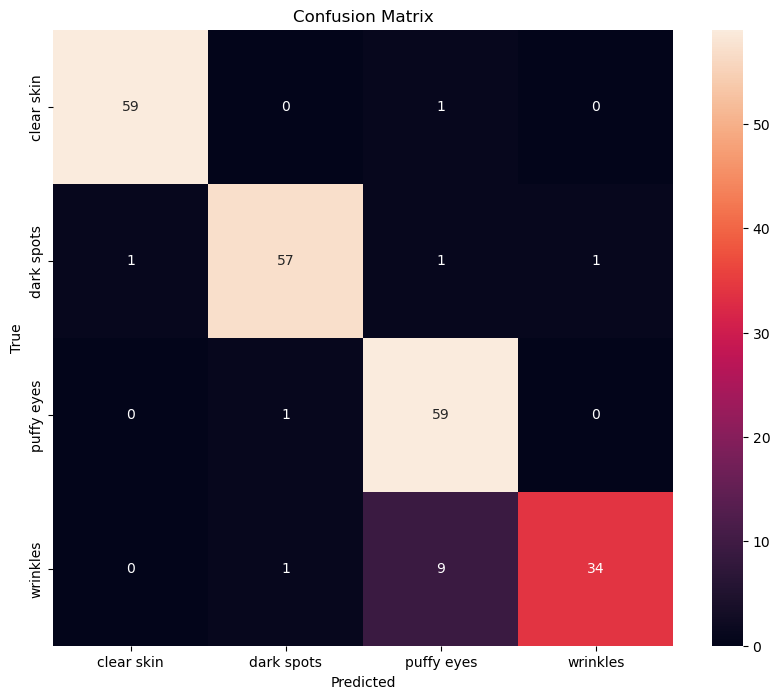


✅ Evaluation metrics saved to output
Classification report: output\classification_report.json
Confusion matrix: output\confusion_matrix.png


In [9]:
# Evaluate model on validation set
print("Evaluating final model...")
final_loss, final_accuracy = model.evaluate(
    validation_generator,
    steps=validation_generator.samples // BATCH_SIZE
)

print(f"\nFinal Validation Loss: {final_loss:.4f}")
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

# Generate predictions for confusion matrix
validation_generator.reset()
predictions = model.predict(
    validation_generator,
    steps=validation_generator.samples // BATCH_SIZE
)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_generator.classes[:len(predicted_classes)]

# Generate classification report
class_names = list(validation_generator.class_indices.keys())
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_names,
    output_dict=True
)

# Save classification report
report_path = os.path.join(OUTPUT_DIR, 'classification_report.json')
with open(report_path, 'w') as f:
    json.dump(report, f, indent=4)

# Create confusion matrix plot
plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Save confusion matrix plot
cm_path = os.path.join(OUTPUT_DIR, 'confusion_matrix.png')
plt.savefig(cm_path)
plt.show()

print(f"\n✅ Evaluation metrics saved to {OUTPUT_DIR}")
print(f"Classification report: {report_path}")
print(f"Confusion matrix: {cm_path}")

In [12]:
def predict_with_confidence(image_path, model, class_labels):
    """
    Predict skin condition with confidence scores
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Get predictions
    predictions = model.predict(img_array)
    
    # Get confidence scores for each class
    results = {}
    for i, score in enumerate(predictions[0]):
        class_name = class_labels[i]
        confidence = float(score * 100)
        results[class_name] = confidence
        
    return results

def analyze_facial_aging(image_path, model, class_labels):
    """
    Analyze facial aging signs in an image and return predictions with confidence scores
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Could not load image")
    
    # Convert to RGB for visualization
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Load the face cascade classifier
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Detect faces
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        # If no faces detected, analyze the whole image
        img_resized = cv2.resize(img, IMG_SIZE)
        img_array = tf.keras.preprocessing.image.img_to_array(img_resized)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        predictions = model.predict(img_array)
        
        # Create a result for the whole image
        results = [{
            'bbox': (0, 0, img.shape[1], img.shape[0]),
            'predictions': {
                class_labels[i]: float(score * 100)
                for i, score in enumerate(predictions[0])
            }
        }]
        return img_rgb, results
    
    results = []
    for (x, y, w, h) in faces:
        # Extract face ROI
        face_roi = img[y:y+h, x:x+w]
        
        # Preprocess ROI for model
        face_roi = cv2.resize(face_roi, IMG_SIZE)
        face_array = tf.keras.preprocessing.image.img_to_array(face_roi)
        face_array = np.expand_dims(face_array, axis=0)
        face_array = preprocess_input(face_array)
        
        # Get predictions
        predictions = model.predict(face_array)
        
        # Get confidence scores
        face_results = {
            'bbox': (x, y, w, h),
            'predictions': {}
        }
        
        for i, score in enumerate(predictions[0]):
            class_name = class_labels[i]
            confidence = float(score * 100)
            face_results['predictions'][class_name] = confidence
            
        results.append(face_results)
    
    return img_rgb, results

def visualize_predictions(image, results):
    """
    Visualize the predictions with bounding boxes and labels
    """
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    
    for result in results:
        x, y, w, h = result['bbox']
        predictions = result['predictions']
        
        # Draw bounding box
        rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
        
        # Format prediction text
        text = []
        for class_name, confidence in predictions.items():
            text.append(f"{class_name}: {confidence:.1f}%")
        
        # Add text above bounding box
        plt.text(x, y-10, '\n'.join(text), 
                bbox=dict(facecolor='white', alpha=0.7),
                fontsize=8, color='black')
    
    plt.axis('off')
    plt.title('Facial Aging Analysis')
    plt.tight_layout()
    return plt

In [16]:
# Test image path
test_image_path = "test1.jpg"
print(f"\nAnalyzing {os.path.basename(test_image_path)}...")

try:
    # Analyze image
    image, results = analyze_facial_aging(test_image_path, model, class_names)
    
    # Visualize results
    plt = visualize_predictions(image, results)
    
    # Save the visualization
    output_path = os.path.join(OUTPUT_DIR, f"prediction_{os.path.basename(test_image_path)}")
    plt.savefig(output_path)
    plt.close()
    
    # Print detailed results
    print("\nDetailed Analysis:")
    for i, result in enumerate(results, 1):
        print(f"\nFace #{i}:")
        for class_name, confidence in result['predictions'].items():
            print(f"{class_name}: {confidence:.1f}%")
            
    print(f"✅ Saved visualization to {output_path}")
        
except Exception as e:
    print(f"Error: {str(e)}")


Analyzing test1.jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

Detailed Analysis:

Face #1:
clear skin: 1.4%
dark spots: 94.9%
puffy eyes: 2.6%
wrinkles: 1.1%
✅ Saved visualization to output\prediction_test1.jpg

Detailed Analysis:

Face #1:
clear skin: 1.4%
dark spots: 94.9%
puffy eyes: 2.6%
wrinkles: 1.1%
✅ Saved visualization to output\prediction_test1.jpg
